## Python in finance

This notebook presents how to: 
- download stock prices of companies
- save and read data as csv or pickle file 
- show relation (coreelation) bettewen companies
- plot ohlc chart 
- update data to csv file

In [104]:
import datetime as dt 
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd 
import numpy as np 
import pandas_datareader.data as web 
import pickle
import os

In [105]:
# style of plots
style.use('ggplot')

### Getting stock prices

In [106]:
# List of ocompanies, which stokcs we'll present 
listOfCompanies = ['TSLA', 'GOOGL', 'FB', 'MSFT', 'AAPL', 'AMZN' ]  # [Tesla, Google, Facebook, Microsoft, Appple, Amazon]

In [107]:
#time range
timePeirod = 30 # in days
today = dt.datetime.today().strftime('%Y-%m-%d') 
start = (dt.datetime.today() - dt.timedelta(timePeirod)).strftime('%Y-%m-%d') 

In [108]:
# Get stocks of companies specified in 'listOfCompanies'. Time range specified above
def get_stocks():
    main_df = pd.DataFrame()
    for company in listOfCompanies:
        # read data from web
        df_company = web.DataReader(company, 'yahoo', start, today)
        # add super column (company name) to data
        df_company.columns = pd.MultiIndex.from_product([[company], df_company], names=['Company','Type of data'])
        
        if main_df.empty: 
            main_df = df_company
        else:
            main_df = main_df.join(df_company, how='right')

    return main_df


In [109]:
df = get_stocks()

### Saving and reading data

In [110]:
# File path where, we save stocks
data_folder_name = "All_stock_data"
file_path_stocks = os.path.join("./",data_folder_name ,"All_data.pickle")


In [111]:
# saving prices of each company separately in csv file
def save_stock_as_csv(folder_name = data_folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    for company in listOfCompanies:
        if not os.path.exists(os.path.join(folder_name, company + ".csv")):
            df[company].to_csv(os.path.join(folder_name, company + ".csv"))
            
save_stock_as_csv()

In [112]:
# Function to save downloaded stocks 
def save_stocks_as_pickle(path=file_path_stocks):
    with open(path, "wb") as f:
        pickle.dump(df, f)

save_stocks_as_pickle()

In [113]:
def read_stocks_pickel(path=file_path_stocks):
    with open(path, "rb") as f:
        return pickle.load(f)

### Finding correlation

In [114]:
def compute_correlation(df_=df, price_type='Adj Close'):
    priceOfCompany = []
    # create array which contain only specified type of price
    for company in df_.columns.levels[0].values: # for company in ['AAPL', 'AMZN', 'FB', 'GOOGL', 'MSFT', 'TSLA']
        priceOfCompany.append((company, price_type))
    # compute correlation
    df_corr = df_[priceOfCompany].corr()
    # drop some column and index levels to better visualization data
    df_corr.columns = df_corr.columns.droplevel(1)
    df_corr.index = df_corr.index.droplevel(1)

    return df_corr
    
df_corr = compute_correlation()

In [115]:
save_stocks_as_pickle(path="./All_stock_data/Correlation.pickle")

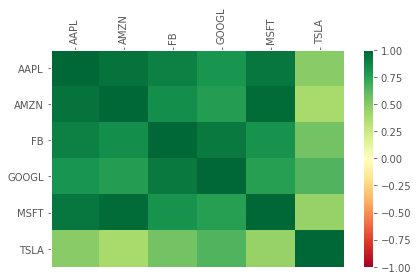

In [116]:
def visualize_corr(df_corr_= df_corr):
    data = df_corr_.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    cloumn_lables = df_corr_.columns
    row_lables = df_corr.index
    
    ax.set_xticklabels(cloumn_lables)
    ax.set_yticklabels(row_lables)
    plt.xticks(rotation=90)
    heatmap.set_clim(-1,1)
    plt.tight_layout()
    plt.show()

visualize_corr(df_corr_ = df_corr)

### Presenting data on OHLC chart

In [117]:
# Import some needed modules
from mpl_finance import candlestick_ohlc # it wants data in format: dates in matplotlib.dates format, open, high, low, close
import matplotlib.dates as mdates

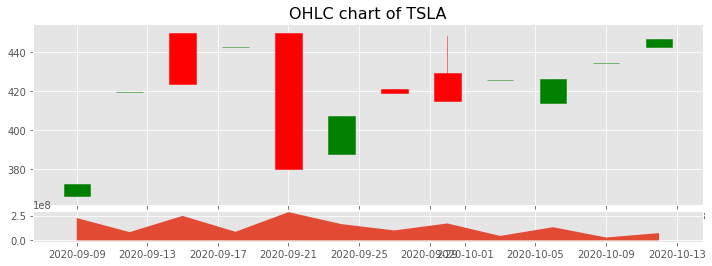

In [118]:
def visualize_ohlc(company):
    df = pd.read_csv('All_stock_data/{}.csv'.format(company), parse_dates=True, index_col=0) 
    df_ohlc = df['Adj Close'].resample('3D').ohlc() #open high low close 
    df_volume = df['Volume'].resample('3D').sum()
    
    #transform index data to numbers
    df_ohlc.reset_index(inplace=True) #restart index to column
    df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num) # convert date format to numbers 
    
    plt.figure(figsize=(12,4))
    
    ax1 = plt.subplot2grid((6,1),(0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((6,1),(5,0), rowspan=1, colspan=1, sharex=ax1)
    ax1.xaxis_date() # display date format on axi x

    candlestick_ohlc(ax1, df_ohlc.values, width=1.5, colorup='g')
    ax2.fill_between(df_volume.index.map(mdates.date2num), df_volume.values, 0) #on y axi fill from 0 to df_volume.values
    
    plt.title('OHLC chart of {}'.format(company), y=7.0, fontdict={'fontsize':16, 'color': 'black'})
    plt.show()

visualize_ohlc('TSLA')

### Updating data

In [119]:
# Function which returns last date, when stock data was aviable
def get_last_date():
    today = dt.datetime.today().strftime('%Y-%m-%d')
    three_days_ago = (dt.datetime.today() - dt.timedelta(3)).strftime('%Y-%m-%d')
    _df = web.DataReader('TSLA', 'yahoo', three_days_ago, today)
    last_date = _df.index[-1].strftime('%Y-%m-%d')
    return last_date

In [120]:
# Upadte data to 'company'.csv file in folder_name 
def update_data(company , folder_name = data_folder_name):
    
    df_ = pd.read_csv(os.path.join(folder_name, company + ".csv"), parse_dates=True, index_col=0)
    
    last_index = df_.index[-1].strftime('%Y-%m-%d')
    last_date = get_last_date()
    
    if not(last_date == last_index):
        one_day_after = (df_.index[-1] + dt.timedelta(1)).strftime('%Y-%m-%d')
        df_update = web.DataReader(company, 'yahoo', one_day_after, last_date)
        df_update.to_csv(os.path.join(folder_name, company + ".csv"), mode='a', header=False)

In [121]:
company = 'TSLA'

# Update data of company
update_data(company)

# Read updated data
tesla_stock = pd.read_csv(os.path.join( data_folder_name, company + ".csv"), parse_dates=True, index_col=0)
tesla_stock.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-09-09,369.000000,341.510010,356.600006,366.279999,79465800,366.279999
2020-09-10,398.989990,360.559998,386.209991,371.339996,84930600,371.339996
2020-09-11,382.500000,360.500000,381.940002,372.720001,60717500,372.720001
2020-09-14,420.000000,373.299988,380.950012,419.619995,83020600,419.619995
2020-09-15,461.940002,430.700012,436.559998,449.760010,97298200,449.760010
